# 

# Intro to Scikit-Learn

From: [Kaggle Temperature-Salinity + Geodata](https://www.kaggle.com/code/angelosorge/temperature-salinity-geodata)

## Regression

### Context

The CalCOFI data set represents the world’s longest (1949-present) and most complete (more than 50,000 sampling stations) oceanographic and larval fish data time series. The physical, chemical, and biological data collected at regular time and space intervals help document climatic cycles in the California Current and a range of biological responses to them. CalCOFI research drew world attention to the biological response to the dramatic Pacific warming event in 1957-58 and introduced the term “El Niño” into the scientific literature.

CalCOFI conducts quarterly cruises off southern and central California, collecting a suite of hydrographic and biological data on the station and underway. Data collected at depths down to 500 m include temperature, salinity, oxygen, phosphate, silicate, nitrate and nitrite, chlorophyll, transmissometer, PAR, C14 primary productivity, phytoplankton biodiversity, zooplankton biomass, and zooplankton biodiversity.

### Scope

We would like to know how we could predict the temperature of the water based on the salinity and the depth, as well as possibly other available features.

In [3]:
import platform
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly
import plotly.express as px
import seaborn as sns
import sklearn
from sklearn import datasets, decomposition, metrics, preprocessing, utils
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from tqdm.notebook import tqdm

### Data

[Main Website: CalCOFI](https://calcofi.com/)

[Bottle-Dataset](https://new.data.calcofi.com/index.php/database/calcofi-database/bottle-field-descriptions)

[Cast-Dataset](https://new.data.calcofi.com/index.php/database/calcofi-database/cast-table-column-descriptions)

In [4]:
%config InlineBackend.figure_format="retina"  # For high DPI display

sns.set_style("darkgrid")
sns.set_context("notebook")

plotly.offline.init_notebook_mode(connected=True)

tqdm.pandas()

print(sklearn.__version__)  # Version tested on sklearn.__version__ == 1.5.x

1.7.2


### Utility Functions

In [5]:
def pprint_var(**kwargs):
    for k, v in kwargs.items():
        print(f"{k} = {v:.4g}")

#### Data loading

In [6]:
DATA = Path("data-tp3")
assert DATA.exists()

In [7]:
bottle_raw_df = pd.read_csv(DATA / "194903-202105_Bottle.csv", low_memory=False, encoding="cp1252")

In [8]:
bottle_info_df = pd.read_csv(
    DATA / "Bottle Field Descriptions.csv",
    encoding="cp1252",
).drop(columns=["Unnamed: 3"])

In [9]:
bottle_info_df[bottle_info_df["Field Name"] == "STheta"]

,Field Name,Units,Description
8,STheta,kilograms per cubic meter,"Potential Density (Sigma Theta), Kg/M³"


In [10]:
bottle_info_df

,Field Name,Units,Description
0,Cst_Cnt,n.a.,"Cast Count - All CalCOFI casts ever conducted,..."
1,Btl_Cnt,n.a.,Bottle Count - All CalCOFI bottles ever sample...
2,Sta_ID,n.a.,Line and Station [Line] [Station]
3,Depth_ID,n.a.,Uses the Cast_ID prefix ([Century]-[Year][Mont...
4,Depthm,meters,Bottle depth in meters
...,...,...,...
57,TA1,micromoles per kilogram,Total Alkalinity micromoles per kilogram solution
58,TA2,micromoles per kilogram,Total Alkalinity micromoles per kilogram solut...
59,pH1,pH scale,pH (the degree of acidity/alkalinity of a solu...
60,pH2,pH scale,pH (the degree of acidity/alkalinity of a solu...


In [11]:
# Reduce the dataframe to the relevant columns (0,4,5,6,7,8) and make a copy called bottle_df
bottle_df = bottle_raw_df.iloc[:, [0, 4, 5, 6, 7, 8]].copy()
del bottle_raw_df
bottle_df

,Cst_Cnt,Depthm,T_degC,Salnty,O2ml_L,STheta
0,1,0,10.500,33.44000,NaN,25.64900
1,1,8,10.460,33.44000,NaN,25.65600
2,1,10,10.460,33.43700,NaN,25.65400
3,1,19,10.450,33.42000,NaN,25.64300
4,1,20,10.450,33.42100,NaN,25.64300
...,...,...,...,...,...,...
895366,35644,304,7.303,26.67160,1.526,26.67160
895367,35644,379,6.606,26.82726,0.843,26.82726
895368,35644,400,6.420,26.86069,0.733,26.86069
895369,35644,500,5.877,27.01054,0.393,27.01054


In [12]:
bottle_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 895371 entries, 0 to 895370
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   Cst_Cnt  895371 non-null  int64  
 1   Depthm   895371 non-null  int64  
 2   T_degC   884402 non-null  float64
 3   Salnty   848015 non-null  float64
 4   O2ml_L   725630 non-null  float64
 5   STheta   842675 non-null  float64
dtypes: float64(4), int64(2)
memory usage: 41.0 MB


#### Cleaning

Remove the NaN values

<span style="color:red">Implement your solution below</span>

In [13]:
bottle_df.dropna(inplace=True)
bottle_df

,Cst_Cnt,Depthm,T_degC,Salnty,O2ml_L,STheta
2160,71,0,10.300,33.03000,5.900,25.36400
2161,71,6,18.460,32.92000,6.020,23.56800
2162,71,10,10.290,32.95100,6.040,25.30400
2163,71,15,10.290,32.99000,6.060,25.33500
2164,71,20,10.330,33.00500,6.040,25.33900
...,...,...,...,...,...,...
895366,35644,304,7.303,26.67160,1.526,26.67160
895367,35644,379,6.606,26.82726,0.843,26.82726
895368,35644,400,6.420,26.86069,0.733,26.86069
895369,35644,500,5.877,27.01054,0.393,27.01054


### Data Analysis

#### Plot Correlation Matrix with Seaborn

<span style="color:red">Implement your solution below</span>

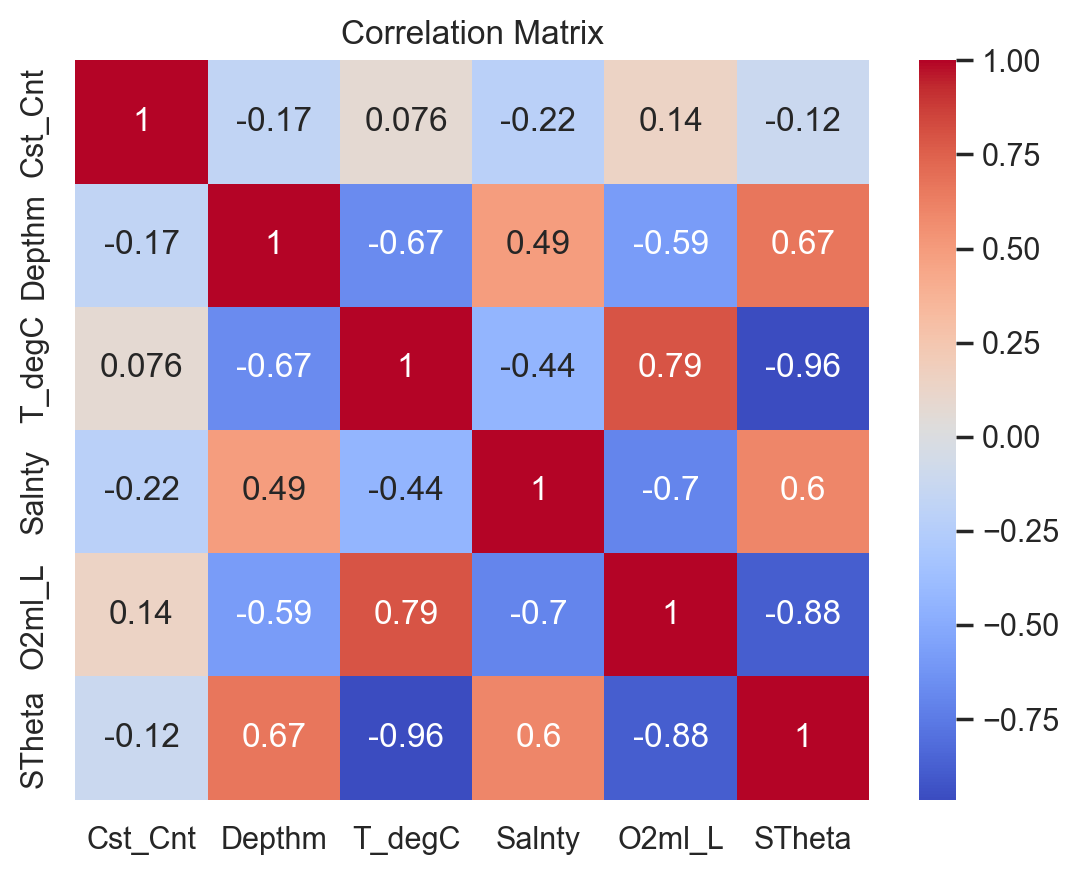

With this confusion matrix, we can see that there is a strong correlation between the 
Bottle Temperature (T_degC) and Oxygen per liter in seawater (O2ml_L). Same, there is 
relatively high correlation between Depth (Depthm) and Potential density (STheta).


In [14]:
sns.heatmap(bottle_df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()
print("With this confusion matrix, we can see that there is a strong correlation between the \n" \
"Bottle Temperature (T_degC) and Oxygen per liter in seawater (O2ml_L). Same, there is \nrelatively " \
"high correlation between Depth (Depthm) and Potential density (STheta).")

#### Correlation Plots

Select from the correlation matrix the 4 features involved in the most correlated pairs and plot their relationship.

<span style="color:red">Implement your solution below</span>

Most correlated features pairs:['T_degC', 'STheta', 'O2ml_L', 'Salnty']


Text(0.5, 1.02, 'Pairplot of the most correlated features')

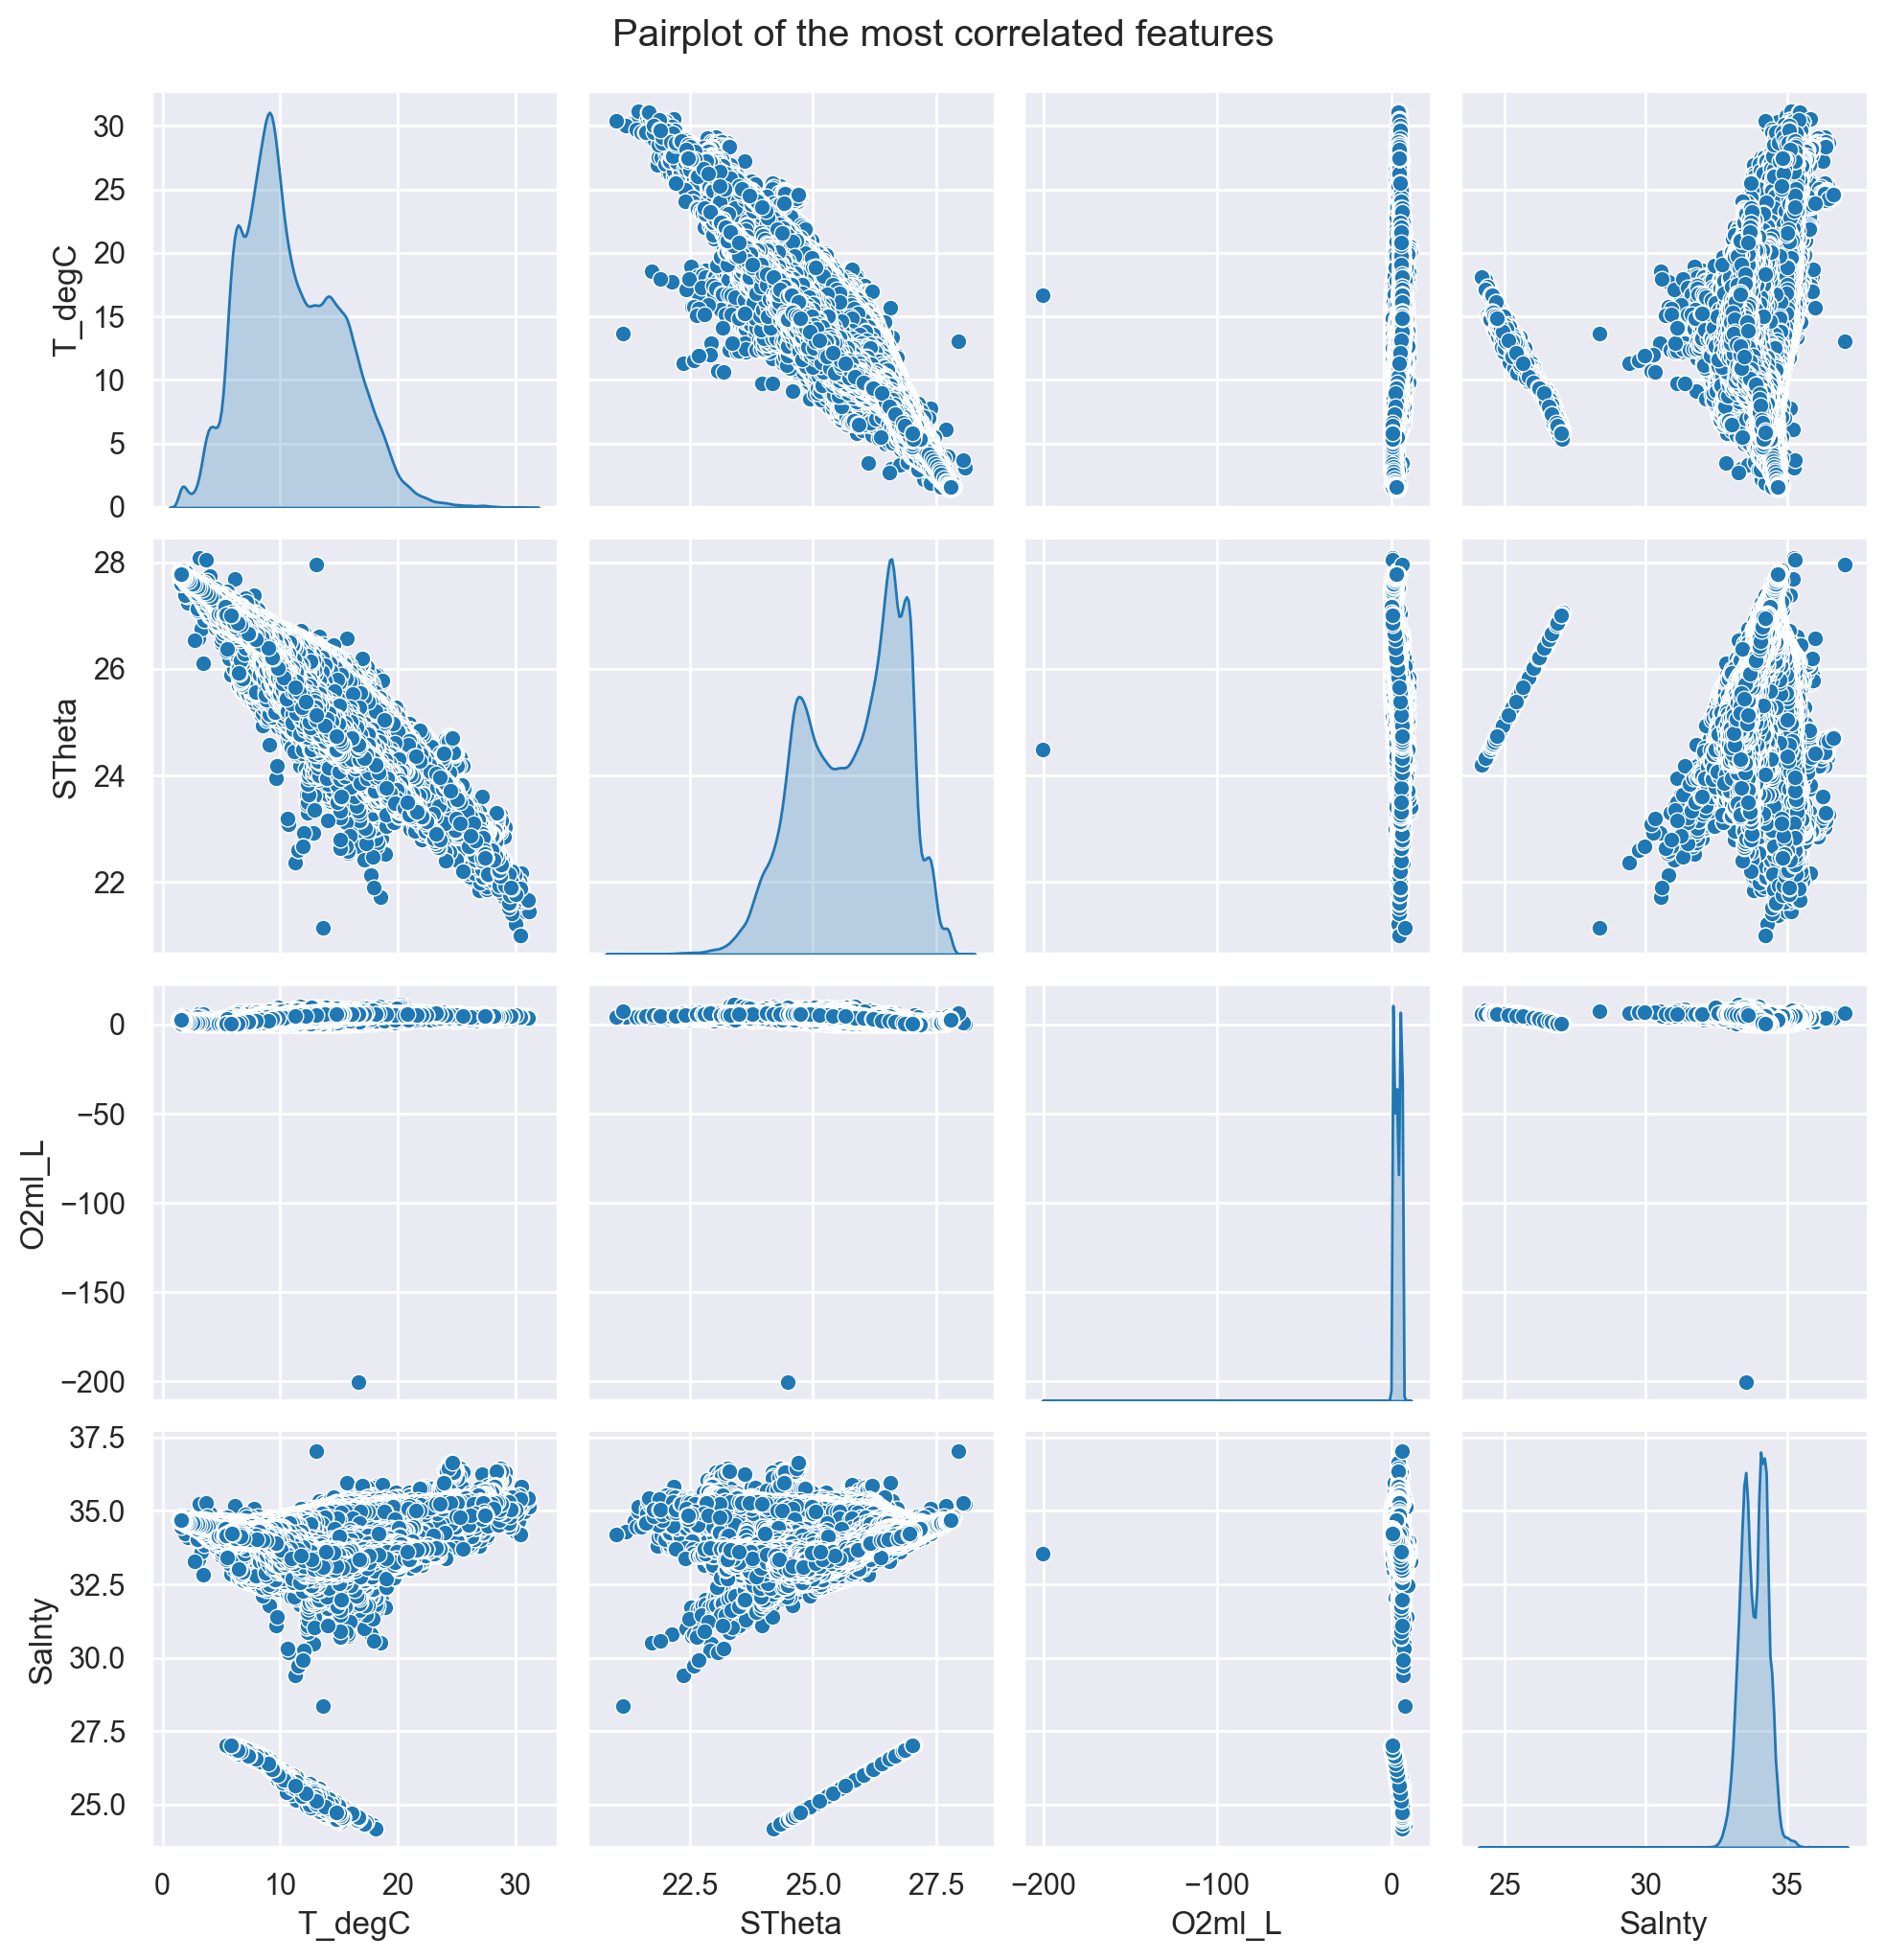

In [15]:
# Compute the correlation matrix
corr = bottle_df.corr().abs()
# Convert the correlation matrix into a list of pairs thanks to the triangular upper matrix
corr_pairs = (
    corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
        .stack()
        .sort_values(ascending=False) # sort by descending order
)
# Select the top 4 features involved in the most correlated pairs
most_corr_features = []
for p in corr_pairs.index:
    f1 = p[0]
    f2 = p[1]
    if f1 not in most_corr_features:
        most_corr_features.append(f1)
    if len(most_corr_features) >= 4:
        break
    if f2 not in most_corr_features:
        most_corr_features.append(f2)
    if len(most_corr_features) >= 4:
        break
print(f"Most correlated features pairs:{most_corr_features}")
# Plot pairplot of the most correlated features
sns.pairplot(bottle_df[most_corr_features], diag_kind="kde")
plt.suptitle("Pairplot of the most correlated features", y=1.02)

#### Depth – Temperature – Salinity

*   The Temperature as a function of the Depth

*   The Salinity as a function of the Depth

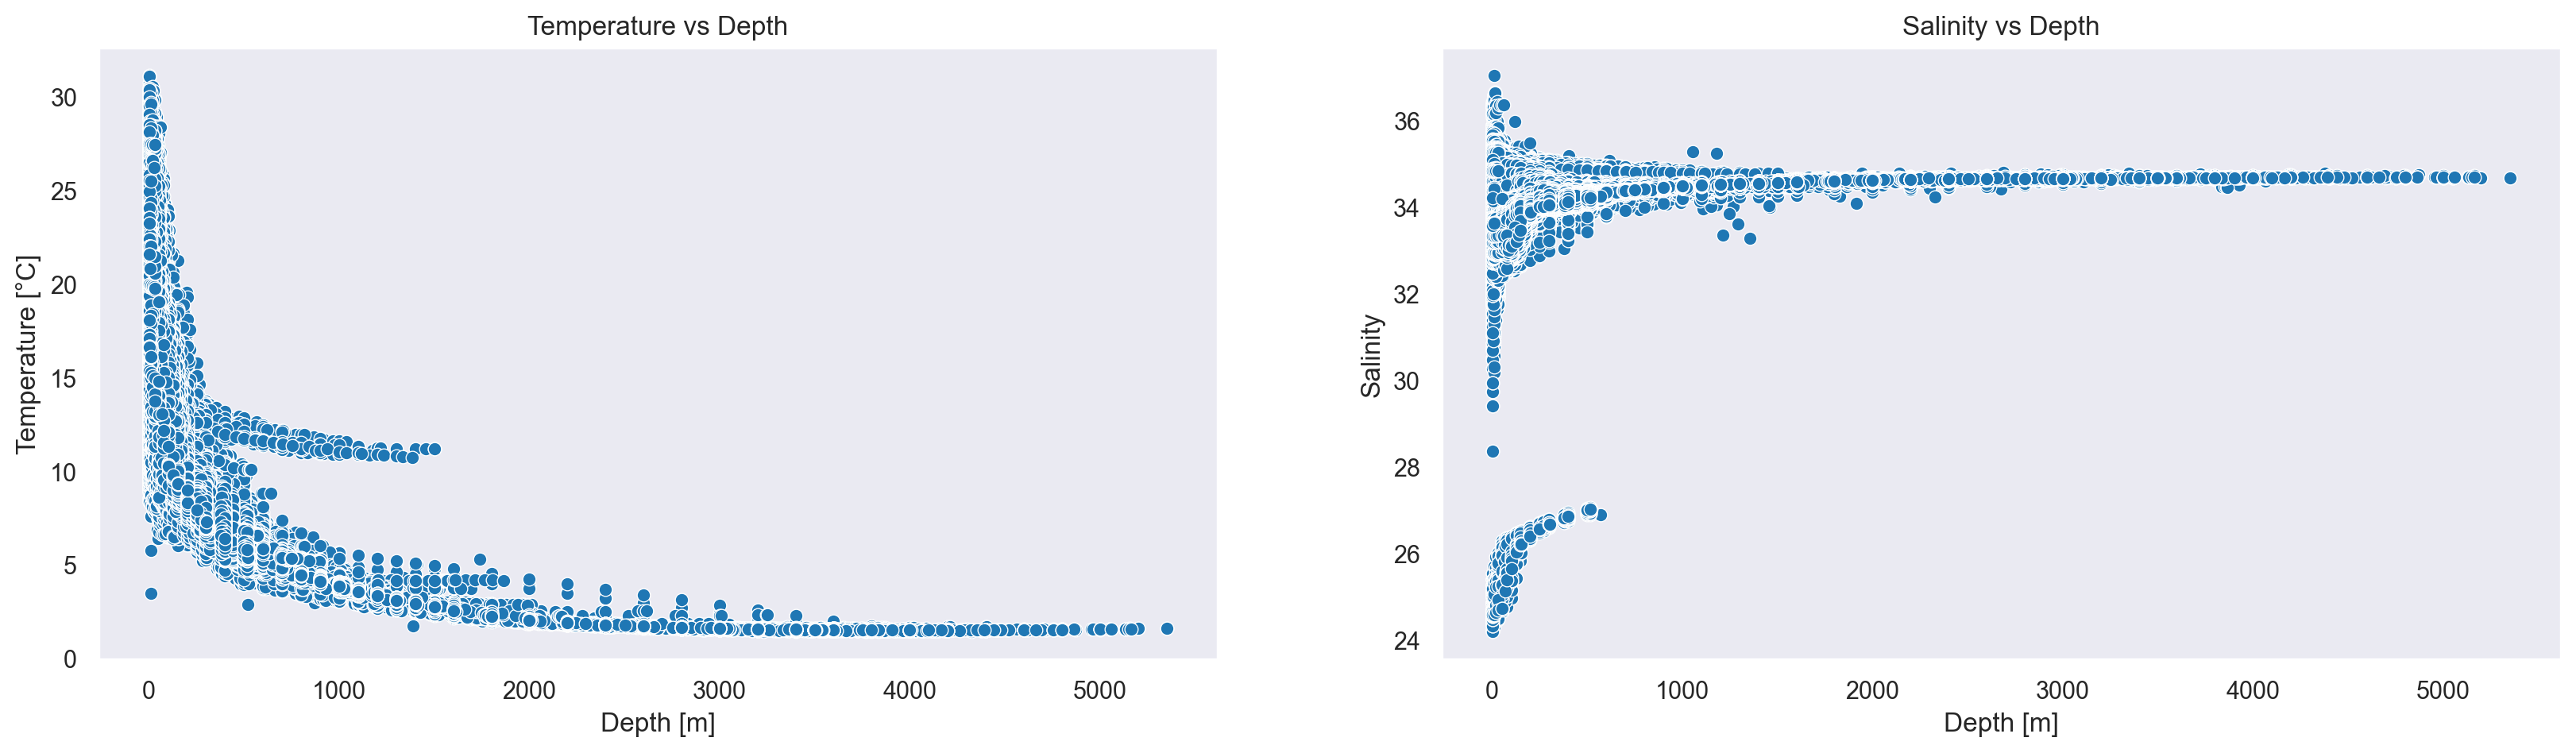

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
g1 = sns.scatterplot(data=bottle_df, x="Depthm", y="T_degC", ax=ax[0])
ax[0].set(
    xlabel="Depth [m]",
    ylabel="Temperature [°C]",
    title="Temperature vs Depth",
)
ax[0].grid()
g2 = sns.scatterplot(data=bottle_df, x="Depthm", y="Salnty", ax=ax[1])
ax[1].set(xlabel="Depth [m]", ylabel="Salinity", title="Salinity vs Depth")
ax[1].grid()

As we can see from the image above, temperature and salinity trace a hyperbolic trend as depth changes:

- In the first plot, some points in the upper part of the image show a different trend from the rest of the graph. It is an unexpected behavior because, for instance, at around 1000 m depth, the expected temperature is around 5°C, but we also find temperatures between 10°C and 15°C (https://www.windows2universe.org/earth/Water/temp.html).

- In the second plot, the points converge asymptotically from both high and low salinity values. It means salinity increases with depth in some ocean areas and vice versa.

Suppose we isolate data points with salinity values in the range above the salinity values in the deepest ocean area. In that case, we observe an alternative trend highlighted in the Temperature-Depth graph.

In [20]:
max_depth_salnty = bottle_df.loc[bottle_df.Depthm.idxmax()].Salnty
max_depth_salnty += 0.1  # Margin to stay on the upper side of the asymptote
pprint_var(max_depth_salnty=max_depth_salnty)

bottle_hi_salt_df = bottle_df[bottle_df.Salnty > max_depth_salnty]
bottle_hi_salt_df   # with max_depth_salnty = 34.85: 6818 rows × 6 columns

max_depth_salnty = 34.78


,Cst_Cnt,Depthm,T_degC,Salnty,O2ml_L,STheta
9204,305,1180,3.10,35.250,0.49,28.083
40328,1303,854,4.01,34.930,1.85,27.736
41497,1339,415,7.80,35.090,0.28,27.381
55857,1809,2142,1.98,34.790,1.85,27.817
55862,1809,2688,1.73,34.810,2.47,27.855
...,...,...,...,...,...,...
479617,19189,11,27.49,34.839,4.62,22.442
479618,19189,20,27.47,34.838,4.59,22.449
479619,19189,30,27.45,34.837,4.55,22.455
479620,19189,31,27.45,34.837,4.55,22.455


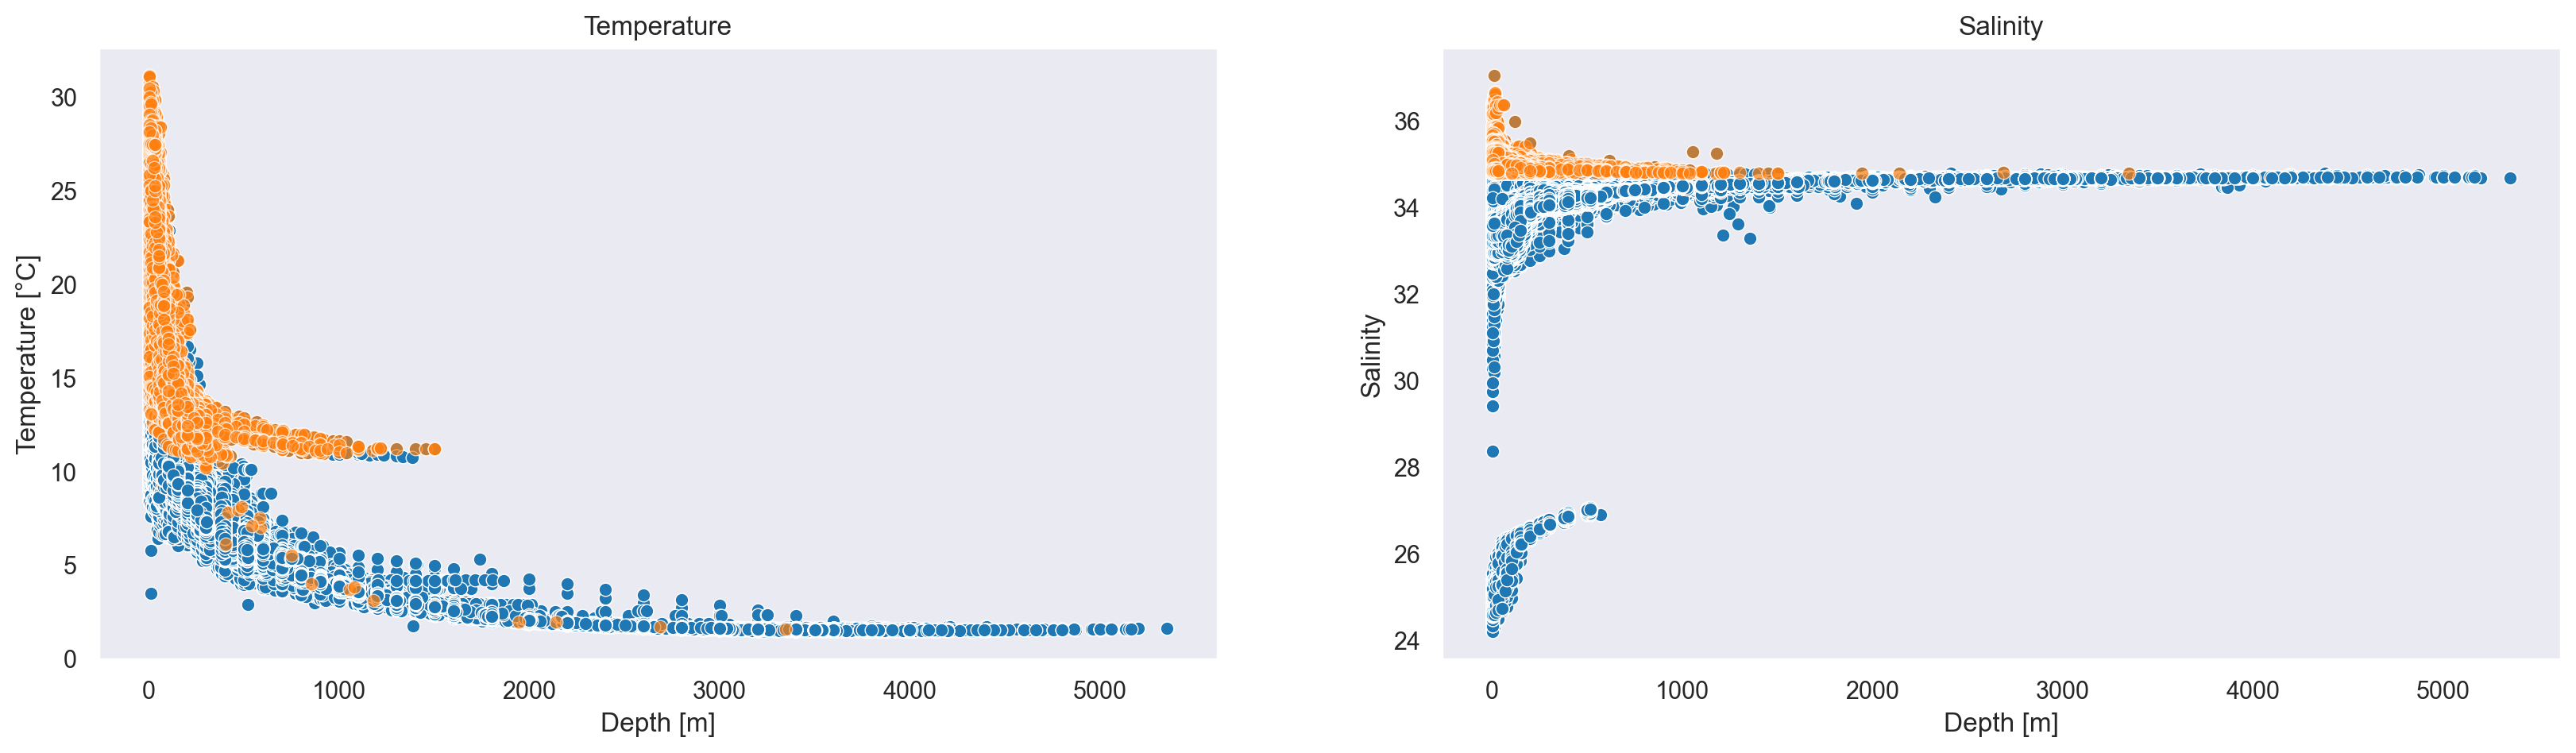

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
g1 = sns.scatterplot(data=bottle_df, x="Depthm", y="T_degC", ax=ax[0])
g1 = sns.scatterplot(
    bottle_hi_salt_df,
    x="Depthm",
    y="T_degC",
    ax=ax[0],
    alpha=0.7,
)
ax[0].set(xlabel="Depth [m]", ylabel="Temperature [°C]", title="Temperature")
ax[0].grid()
g2 = sns.scatterplot(data=bottle_df, x="Depthm", y="Salnty", ax=ax[1])
g2 = sns.scatterplot(
    data=bottle_hi_salt_df, x="Depthm", y="Salnty", ax=ax[1], alpha=0.7
)
ax[1].set(xlabel="Depth [m]", ylabel="Salinity", title="Salinity")
ax[1].grid()

### Predictive Models

#### Splitting the Dataset

<span style="color:red">Implement your solution below</span>

In [33]:
# Supervised learning task: predict T_degC from the other features
X = bottle_df.loc[:, bottle_df.columns != "T_degC"]  # Features
y = bottle_df["T_degC"]                  # Target variable

# 25% test size and random state 42
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

#### Linear Regression

*   Try predicting the temperature based on depth only.

*   Evaluate the model using the RMSE and the R2 score.

*   Plot the test data and the predicted line.

<span style="color:red">Implement your solution below</span>

rmse = 3.127
r2_score = 0.4457
--- Analysis of the results ---
On one hand, the R2 score measures how well the model predictions approximate the true target values.
In fact, R2 score compares the linear regression model to a simple model that always predicts the mean of the temperatures.
Here, the computed R2 score (0.4457) indicates that the model is better than predicting the mean.
In other hands, the RMSE gives an idea of the average error magnitude between the predicted and actual temperature values.
It expresses the prediction accuracy in the same units as the target variable (°C).In our case, the RMSE of 3.1269 °C 
indicates that, on average, the model's predictions deviate from the actual temperatures by this amount.


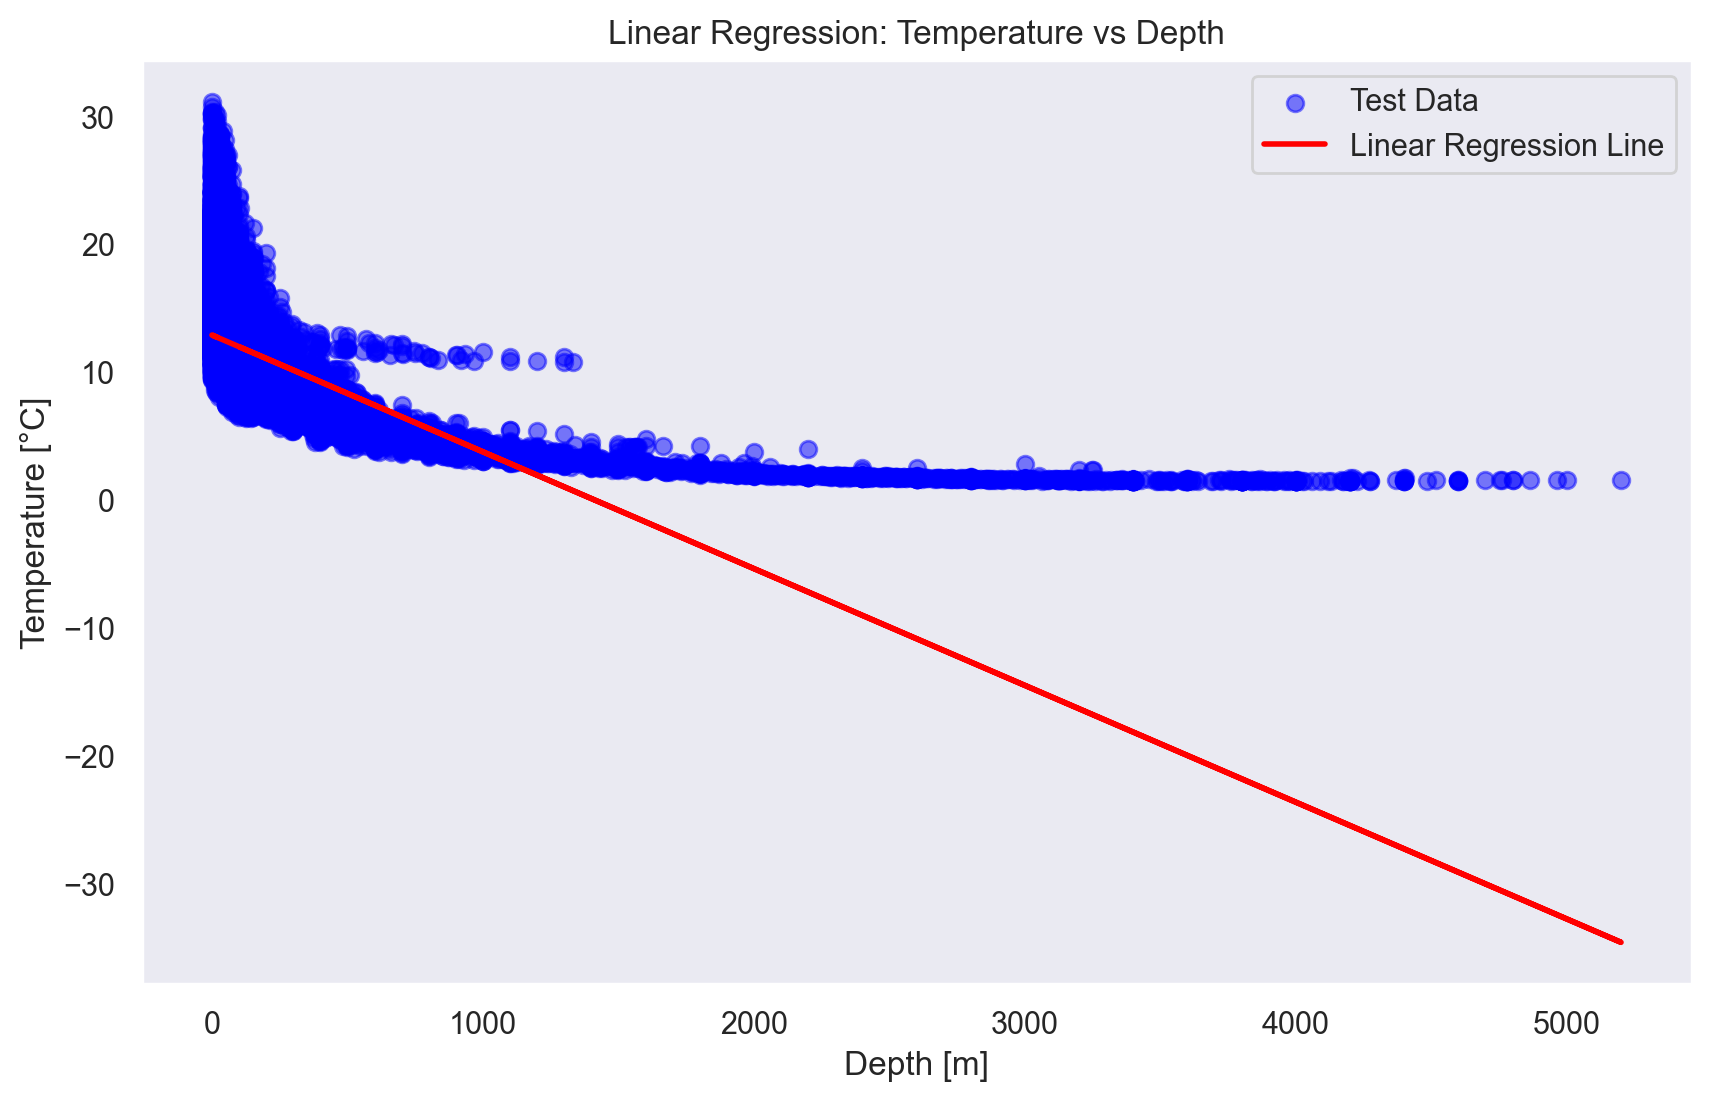

In [34]:
# Extract the depth feature from X_train and X_test
X_train_depth = X_train[["Depthm"]]
X_test_depth = X_test[["Depthm"]]

# Fit the model to predict the temperature from the depth
lin_reg = LinearRegression()
lin_reg.fit(X_train_depth, y_train)

# Compute predictions on the test set
y_pred = lin_reg.predict(X_test_depth)

# Evaluate the model performance
rmse = metrics.root_mean_squared_error(y_test, y_pred)
r2_score = metrics.r2_score(y_test, y_pred)
pprint_var(rmse=rmse, r2_score=r2_score)

print("--- Analysis of the results ---")
print("On one hand, the R2 score measures how well the model predictions approximate the true target values.")
print("In fact, R2 score compares the linear regression model to a simple model that always predicts the mean of the temperatures.")
print(f"Here, the computed R2 score ({r2_score:.4f}) indicates that the model is better than predicting the mean.")
print("In other hands, the RMSE gives an idea of the average error magnitude between the predicted and actual temperature values.\n" \
"It expresses the prediction accuracy in the same units as the target variable (°C)." \
"In our case, the RMSE of {:.4f} °C \nindicates that, on average, the model's predictions deviate from the actual temperatures by this amount.".format(rmse))

# Plot the data points and the linear regression line
plt.figure(figsize=(10, 6))
plt.scatter(X_test_depth, y_test, color="blue", label="Test Data", alpha=0.5)
#plt.scatter(X_train_depth, y_train, color="green", label="Train Data", alpha=0.5)
plt.plot(X_test_depth, y_pred, color="red", linewidth=2, label="Linear Regression Line")
plt.xlabel("Depth [m]")
plt.ylabel("Temperature [°C]")
plt.title("Linear Regression: Temperature vs Depth")
plt.legend()
plt.grid()
plt.show()


### Polynomial Regression

*   Adapt linear regression by transforming data according to basis functions

*   E.g., with a polynomial projection:
    $$\hat{y} = a_0 + a_1 x + a_2 x^2 + \cdots + a_n x^n$$

*   Note that this is still a linear model

    *   It is linear in the sense that we never multiply or divide the coefficients

    *   The one-dimensional descriptor $x$ is projected in one or more dimensions to allow modeling more complex relations between $x$ and $y$

*   Try predicting the temperature based on depth only using a polynomial regression (e.g., until `degree=5`).

*   Evaluate the model using the RMSE and the R2 score.

*   Plot the test data and the predicted curve.

<span style="color:red">Implement your solution below</span>

c:\Users\jdorn\Documents\MasterAI\HandsOnMLGitHub\Hands-on-ML\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but PolynomialFeatures was fitted with feature names



rmse = 3.839
r2_score = 0.1646
--- Analysis of the results ---
By introducing the polynomial features, the model shows a lower R2 score and a higher RMSE compared to the linear regression model.
This suggests that the polynomial regression model is less effective and adapted for predicting temperature from depth.


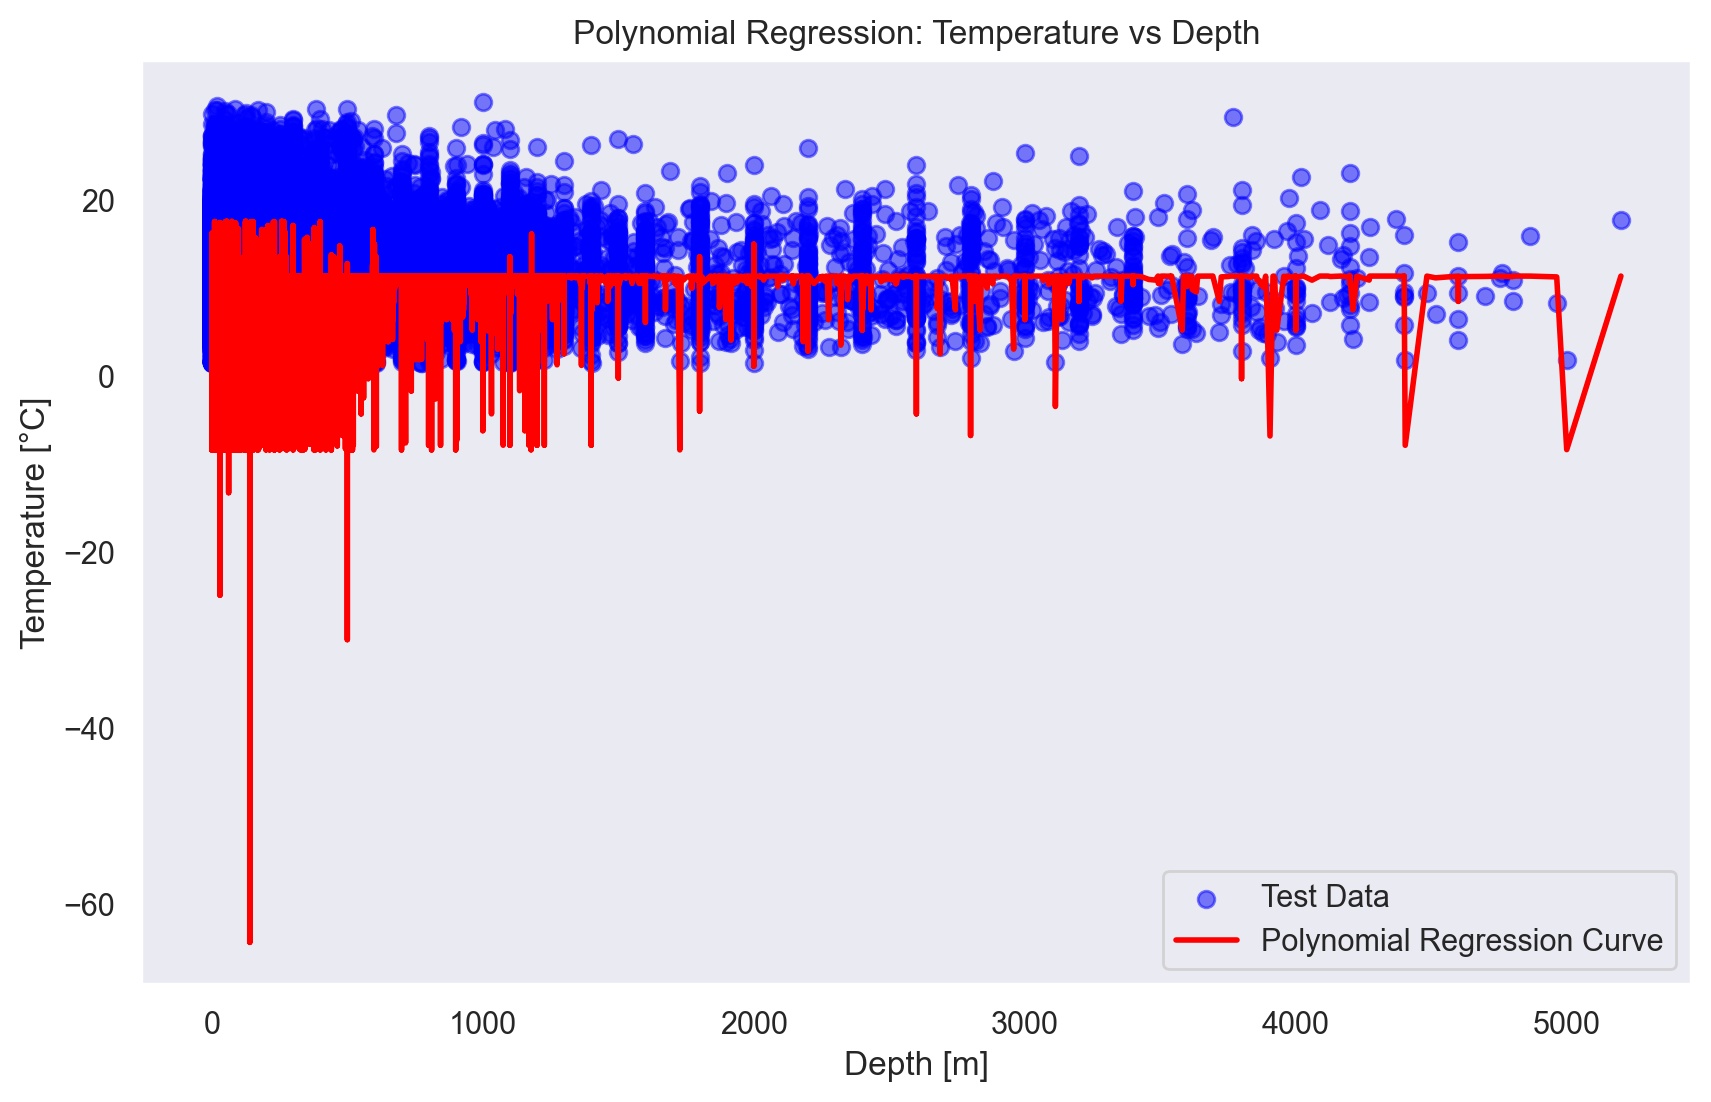

In [49]:
# Transform the linear regression into a polynomial regression by extending the features x
# Polynomial features (x, x^2, x^3, ...) are basis functions.
poly = preprocessing.PolynomialFeatures(degree=5)
X_train_poly = poly.fit_transform(X_train_depth)
X_test_poly = poly.transform(X_test_depth)

X_test_sorted = np.sort(X_test_depth.values, axis=0)
X_test_sorted_poly = poly.transform(X_test_sorted)

# Construct and train the polynomial regression model
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)

# Predict on the test set
y_poly_pred = poly_model.predict(X_test_poly)
y_pred_sorted_poly = poly_model.predict(X_test_sorted_poly)

# Evaluate the polynomial model performance
rmse = metrics.root_mean_squared_error(y_test, y_poly_pred)
r2_score = metrics.r2_score(y_test, y_poly_pred)
pprint_var(rmse=rmse, r2_score=r2_score)

print("--- Analysis of the results ---")
print("By introducing the polynomial features, the model shows a lower R2 score and a higher RMSE compared to the linear regression model.")
print("This suggests that the polynomial regression model is less effective and adapted for predicting temperature from depth.")

# Plot the test data points and the polynomial regression curve
plt.figure(figsize=(10, 6))
plt.scatter(X_test_sorted, y_test, color="blue", label="Test Data", alpha=0.5)
plt.plot(X_test_sorted, y_poly_pred, color="red", linewidth=2, label="Polynomial Regression Curve")
plt.xlabel("Depth [m]")
plt.ylabel("Temperature [°C]")
plt.title("Polynomial Regression: Temperature vs Depth")
plt.legend()
plt.grid()
plt.show()


#### Multiple Linear Regression

*   Perform the linear regression again using the set of 5 features available instead of just one.

*   Evaluate the performance of the regression in terms of MSE and $R^2$.

*   Identify the features that seem the most significant for this regression, by observing the value of their respective parameter ($a_j$ via `model.coef_`).

*   Comment succinctly.

<span style="color:red">Implement your solution below</span>

In [57]:
# Create and train the linear regression model for the fifth features
lin_reg_full = LinearRegression()
lin_reg_full.fit(X_train, y_train)

# Predict on the test set
y_full_pred = lin_reg_full.predict(X_test)

# Evaluate the full feature model performance
rmse = metrics.root_mean_squared_error(y_test, y_full_pred)
r2_score = metrics.r2_score(y_test, y_full_pred)
pprint_var(rmse=rmse, r2_score=r2_score)

print("--- Analysis of the results ---")
print("By utilizing all features, the linear regression model acheive better performance.\n" \
"Indeed, the R2 score is higher and near to 1, indicating a good predictions.\n" \
"In addition the RMSE is lower, expressing a better match between predictions \nand actual target values."  )

# Identify the most significant features
print(f"Model coefficients (by feature):\n{dict(zip(X.columns, lin_reg_full.coef_))}")
significant_features = sorted(
    zip(X.columns, np.abs(lin_reg_full.coef_)),
    key=lambda x: x[1],
    reverse=True,
)[:3]
print(f"The most significant features are:\n{significant_features}")

print("--- Analysis ---")
print("The observed significant features correspond to those with high correlation to the temperature as seen previously for the correlation matrix.\n" \
      "This confirms that features with strong correlation to the target variable tend to have a greater influence on the model's predictions.")

rmse = 0.7434
r2_score = 0.9687
--- Analysis of the results ---
By utilizing all features, the linear regression model acheive better performance.
Indeed, the R2 score is higher and near to 1, indicating a good predictions.
In addition the RMSE is lower, expressing a better match between predictions 
and actual target values.
Model coefficients (by feature):
{'Cst_Cnt': np.float64(-4.1574855276479625e-06), 'Depthm': np.float64(-0.001054554010331543), 'Salnty': np.float64(1.5513249512593599), 'O2ml_L': np.float64(-0.24366548837590776), 'STheta': np.float64(-4.763469909969068)}
The most significant features are:
[('STheta', np.float64(4.763469909969068)), ('Salnty', np.float64(1.5513249512593599)), ('O2ml_L', np.float64(0.24366548837590776))]
--- Analysis ---
The observed significant features correspond to those with high correlation to the temperature as seen previously for the correlation matrix.
This confirms that features with strong correlation to the target variable tend to have a 

### Standardization and PCA

Apply standardization and PCA to the dataset and repeat the regression and the evaluations.

The goal is to see if the performance of the regression improves and if the features that are the most significant change.

Try to analyze the results and comment on your observations (possibly with tables and plots similar to those in the PCA notebook).

<span style="color:red">Implement your solution below</span>

---